In [1]:
import functions_new as func
import importlib
importlib.reload(func)

###########################################################################################################################################

import numpy as np
import matplotlib.pyplot as plt
import random as rd
from IPython.display import clear_output
import time

In [2]:
import numba
from numba.experimental import jitclass
from numba import njit

In [3]:
import numpy as np
import numba as nb

spec = [
    ('type', nb.int32),
    ('val', nb.float64[:]),
    ('result', nb.float64)
]

@nb.experimental.jitclass(spec)
class First:
    def __init__(self):
        self.type = 1
        self.val = np.ones(100)
        self.result = 0.
    def sum(self):
        self.result = np.sum(self.val)

spec1 = [('ListA',  nb.types.List(First.class_type.instance_type, reflected=True))]

@nb.experimental.jitclass(spec1)
class Combined:
    def __init__(self):
        self.ListA = [First(), First()] 
    def sum(self):
        for i, c in enumerate(self.ListA):
            c.sum()
    def getresult(self):
        result = []
        for i, c in enumerate(self.ListA):
            result.append(c.result)
        return result

C = Combined()
C.sum()
print(numba.typeof(C))
result = C.getresult()
print(result)


instance.jitclass.Combined#21c84b07f48<ListA:reflected list(instance.jitclass.First#21c84afce08<type:int32,val:array(float64, 1d, A),result:float64>)<iv=None>>
[100.0, 100.0]


In [661]:
from numba.typed import List
mylist = List()
mylist.append(Agent(10))

In [64]:
@numba.njit
def create_agents_jit(N = 100, average = 25, deviation = 10):
    """
    Inputs:
        N := total number of agents
        average := average value of the normal distribution
        deviation := standard deviation of the normal distribution
        
        The function creates an array of Agents according with the normal distribution of threshold values
        
    Outputs:
        agents := array with all Agents
    
    """
    
    agents = numba.typed.List()
    
    thresholds = create_thresholds_jit(N, average, deviation)
    
    for i in range(N):
        agents.append(Agent(thresholds[i]))
        
    return agents

In [65]:
aux = Agent(10)
empty_list_of_floats = numba.typed.List.empty_list(numba.typeof(aux),10)
print(numba.typeof(aux))
print(numba.typeof(Agent(10)))

instance.jitclass.Agent#23130aa9108<threshold:int64,wish:int64,sector:int64,state:int64>
instance.jitclass.Agent#23130aa9108<threshold:int64,wish:int64,sector:int64,state:int64>


In [66]:
lista = numba.typed.List()
lista.append(Agent(10))
numba.typeof(lista)

ListType[instance.jitclass.Agent#23130aa9108<threshold:int64,wish:int64,sector:int64,state:int64>]

In [67]:
agents = create_agents_jit(200,10,10)
system = System(agents,100,100)

In [25]:
system.update_wishes_reservoir()             # check reservoir Agents (enter riot)
system.update_wishes_sectors_exit()          # check sectors Agents (leave riot)
system.update_reservoir()                    # move Agents from reservoir
system.update_sectors() 
print(len(system.reservoir))
print(len(system.sector0))
print(len(system.sector1))
print(len(system.reservoir)+len(system.sector0)+len(system.sector1))

0
100
100
200


In [883]:
a = [3,4,5,6,7,8,9]
a = a.pop(1)
a

4

In [3]:
spec2 = [
    ('threshold', numba.int64),               
    ('wish', numba.int64),
    ('sector', numba.int64),
    ('state', numba.int64),
]

@jitclass(spec2)
class Agent():
    
    def __init__(self, threshold):
        self.threshold = threshold
        self.wish = -1
        self.sector = -1
        self.state = 0
    
    
    def threshold_model(self, percentage):
        m = 0.2                                                                # if m -> inf, the model approaches the Granovetter's binary model of thresholds.
        probability = 1 / (1 + np.exp( m * (self.threshold - percentage) ) )   # stochastic model of thresholds [0 <= percentage <= 100]
        return probability
    
        
    # updates the state of an agent according with it's threshold, returns 1 if the agent enters the riot, for exemple, and returns 0 if nothing changes.     
    def update_state(self, percentage):              
        rnd = rd.random()
        if self.state == 0:
            if rnd <= self.threshold_model(percentage):
                self.state = 1
                return 1
            else:
                return 0
        else:
            return 0

        
    # updates the state of an agent according with it's threshold, returns 1 if the agent enters the riot, returns 0 if nothing chances and returns -1 if the agent exits the riot.
    def update_state_exit(self, percentage):  
        rnd = rd.random()
        if self.state == 0:
            if rnd <= self.threshold_model(percentage):
                self.state = 1
                return 1
            else:
                return 0
        else:
            if rnd > self.threshold_model(percentage):
                self.state = 0
                return -1
            else:
                return 0

In [132]:
lista = numba.typed.List()
lista.append(Agent(10))
lista.clear()

spec1 = [
    ('reservoir', numba.typeof(lista)),               
    ('sector0', numba.typeof(lista)),
    ('sector0_size', numba.int64),
    ('sector1', numba.typeof(lista)),
    ('sector1_size', numba.int64),
]

@jitclass(spec1)
class System:
    
    # creates a system to be simulated. With one reservoir of Agents, and two riot sectors
    def __init__(self, agents, sector0_size, sector1_size):
        self.reservoir = agents
        self.sector0 = numba.typed.List([Agent(1)])
        self.sector0.clear()
        self.sector0_size = sector0_size
        self.sector1 = numba.typed.List([Agent(1)])
        self.sector1.clear()
        self.sector1_size = sector1_size
     
    
    # migrates an Agent "i" from the sector "sector"
    def migrate(self, sector, i):
        if sector == 0:
            agent = self.sector0[i]
            self.sector0.pop(i)
            self.sector1.append(agent)
            
        else:
            agent = self.sector1[i]
            self.sector1.pop(i)
            self.sector0.append(agent)
     
    
    # checks which Agent, in the reservoir, wants to riot according to it's threshold. It can go in sector 0 or 1.         
    def update_wishes_reservoir(self):
        for i in range(len(self.reservoir)):
            num = rd.randint(0,1)
            rnd = rd.random()
            if num == 0:
                if len(self.sector0) < self.sector0_size:
                    percentage = len(self.sector0)/self.sector0_size * 100
                    if rnd <= self.reservoir[i].threshold_model(percentage):
                        self.reservoir[i].wish = 0
                        continue
                
                if len(self.sector1) < self.sector1_size:                    
                    percentage = len(self.sector1)/self.sector1_size * 100
                    if rnd <= self.reservoir[i].threshold_model(percentage):
                        self.reservoir[i].wish = 1
                        continue
                    
            else:
                if len(self.sector1) < self.sector1_size:                    
                    percentage = len(self.sector1)/self.sector1_size * 100
                    if rnd <= self.reservoir[i].threshold_model(percentage):
                        self.reservoir[i].wish = 1
                        continue
                    
                if len(self.sector0) < self.sector0_size:
                    percentage = len(self.sector0)/self.sector0_size * 100
                    if rnd <= self.reservoir[i].threshold_model(percentage):
                        self.reservoir[i].wish = 0
                        continue
    
    
    # checks which Agent, in both sectros, wants to exit the riot.              
    def update_wishes_sectors_exit(self):
        for i in range(len(self.sector0)):
            rnd = rd.random()
            percentage = len(self.sector0)/self.sector0_size * 100
            if rnd > self.sector0[i].threshold_model(percentage):
                self.sector0[i].wish = -1
                
        for i in range(len(self.sector1)):
            rnd = rd.random()
            percentage = len(self.sector1)/self.sector1_size * 100
            if rnd > self.sector1[i].threshold_model(percentage):
                self.sector1[i].wish = -1
     
    
    # checks which Agent, on both sectors, wants to migrate to other sector (random model)
    def update_wishes_sectors_migration_random(self,migration_probability):
        for i in range(len(self.sector0)):
            rnd = rd.random()
            if rnd <= migration_probability:
                self.sector0[i].wish = 1
                
        for i in range(len(self.sector1)):
            rnd = rd.random()
            if rnd <= migration_probability:
                self.sector1[i].wish = 0
                
                
    # checks which Agent, on both sectors, wants to migrate to other sector (gregarious model)             
    def update_wishes_sectors_migration_gregarious(self):
        m = 1e-3
        dif = len(self.sector1) - len(self.sector0)
        probability = 1 - np.exp(-m * dif)
        
        for i in range(len(self.sector0)):
            rnd = rd.random()
            if dif > 0 and rnd <= probability:
                self.sector0[i].wish = 1
                
        dif = len(self.sector0) - len(self.sector1)
        probability = 1 - np.exp(-m * dif)
        
        for i in range(len(self.sector1)):
            rnd = rd.random()
            if dif > 0 and rnd <= probability:
                self.sector1[i].wish = 0
    
    
    # moves the Agents from the reservoir to the sectors of their wishes values
    def update_reservoir(self):
        i = 0
        while i < len(self.reservoir):
            if self.reservoir[i].wish == 0 and len(self.sector0) < self.sector0_size:
                agent = self.reservoir[i]
                self.reservoir.pop(i)
                self.sector0.append(agent)
                agent.sector = agent.wish
                i -= 1
            elif self.reservoir[i].wish == 1 and len(self.sector1) < self.sector1_size:
                agent = self.reservoir[i]
                self.reservoir.pop(i)
                self.sector1.append(agent)
                agent.sector = agent.wish
                i -= 1
            else:
                self.reservoir[i].wish = self.reservoir[i].sector
            i += 1
    
    
    # moves the Agents from the sectors to the reservoir or to the other sector
    def update_sectors(self):
        i = 0
        while i < len(self.sector0):
            if self.sector0[i].wish == -1:
                agent = self.sector0[i]
                self.sector0.pop(i)
                self.reservoir.append(agent)
                agent.sector = agent.wish
                i -= 1
            elif self.sector0[i].wish == 1 and len(self.sector1) < self.sector1_size:
                agent = self.sector0[i]
                self.sector0.pop(i)
                self.sector1.append(agent)
                agent.sector = agent.wish
                i -= 1
            else:
                self.sector0[i].wish = self.sector0[i].sector
            i += 1
            
        i = 0
        while i < len(self.sector1):
            if self.sector1[i].wish == -1:
                agent = self.sector1[i]
                self.sector1.pop(i)
                self.reservoir.append(agent)
                agent.sector = agent.wish
                i -= 1
            elif self.sector1[i].wish == 0 and len(self.sector0) < self.sector0_size:
                agent = self.sector1[i]
                self.sector1.pop(i)
                self.sector0.append(agent)
                agent.sector = agent.wish
                i -= 1
            else:
                self.sector1[i].wish = self.sector1[i].sector
            i += 1

In [485]:
def create_thresholds(N = 100, a = True, average = 25, deviation = 10):
    """
    Inputs:
        Sample parameters:
          N := total number of agents
          a := if a == True all thresholdds below 0 are converted to 0 and all thresholds above 100 are converted to 100, otherwise nothing happens
        Normal distribution parameters:
          average := average value of the normal distribution
          deviation := standard deviation of the normal distribution
    
    This function creates an array with N threshold values (0 <= x <= 100) according with a normal distribution with the given parameters
          
    Outputs:      
        A np.array with the sorted thresholds values
    
    """
    thresholds = np.empty(N)
    
    # generating the values
    for i in range(N):
        threshold = rd.gauss(average, deviation)     # generates a random value according with a normal distribution

        if a:
            # all thresholdds below 0 are converted to 0 and all thresholds above 100 are converted to 100
            if threshold < 0:
                threshold = 0
            elif threshold > 100:
                threshold = 100

        thresholds[i] = threshold
    print(numba.typeof(thresholds))
    thresholds = sorted(thresholds) #sorts the array
    print(numba.typeof(thresholds))
    return thresholds

In [486]:
%time _ = create_thresholds(100000,10,10)

array(float64, 1d, C)
reflected list(float64)<iv=None>
Wall time: 152 ms


In [684]:
# RUIM #
@numba.njit
def create_thresholds(N = 100, a = True, average = 25, deviation = 10):
    """
    Inputs:
        Sample parameters:
          N := total number of agents
          a := if a == True all thresholdds below 0 are converted to 0 and all thresholds above 100 are converted to 100, otherwise nothing happens
        Normal distribution parameters:
          average := average value of the normal distribution
          deviation := standard deviation of the normal distribution
    
    This function creates an array with N threshold values (0 <= x <= 100) according with a normal distribution with the given parameters
          
    Outputs:      
        A np.array with the sorted thresholds values
    
    """
    thresholds = numba.typed.List.empty_list(numba.types.float64)
    
    # generating the values
    for i in range(N):
        threshold = rd.gauss(average, deviation)     # generates a random value according with a normal distribution

        if a:
            # all thresholdds below 0 are converted to 0 and all thresholds above 100 are converted to 100
            if threshold < 0:
                threshold = 0
            elif threshold > 100:
                threshold = 100

        thresholds.append(threshold)
        
    thresholds = sorted(thresholds) #sorts the array
    
    return thresholds

In [696]:
%time _ = create_thresholds(100000,10,10)

Wall time: 17 ms


In [489]:
@numba.njit(parallel=True)
def create_thresholds_jit_parallel(N = 100, average = 25, deviation = 10):
    """
    Inputs:
        Sample parameters:
          N := total number of agents
          a := if a == True all thresholdds below 0 are converted to 0 and all thresholds above 100 are converted to 100, otherwise nothing happens
        Normal distribution parameters:
          average := average value of the normal distribution
          deviation := standard deviation of the normal distribution
    
    This function creates an array with N threshold values (0 <= x <= 100) according with a normal distribution with the given parameters
          
    Outputs:      
        A np.array with the sorted thresholds values
    
    """
    thresholds = np.zeros(N, dtype = 'float64')
    
    # generating the values
    for i in range(N):
        threshold = rd.gauss(average, deviation)     # generates a random value according with a normal distribution

        # all thresholdds below 0 are converted to 0 and all thresholds above 100 are converted to 100
        if threshold < 0:
            threshold = 0
        elif threshold > 100:
            threshold = 100

        thresholds[i] = threshold
        
    thresholds = sorted(thresholds) #sorts the array
    
    return thresholds

In [12]:
@numba.njit
def create_thresholds_jit(N = 100, average = 25, deviation = 10):
    """
    Inputs:
        Sample parameters:
          N := total number of agents
          a := if a == True all thresholdds below 0 are converted to 0 and all thresholds above 100 are converted to 100, otherwise nothing happens
        Normal distribution parameters:
          average := average value of the normal distribution
          deviation := standard deviation of the normal distribution
    
    This function creates an array with N threshold values (0 <= x <= 100) according with a normal distribution with the given parameters
          
    Outputs:      
        A np.array with the sorted thresholds values
    
    """
    
    thresholds = np.zeros(N, dtype = 'float64')
    
    # generating the values
    for i in range(N):
        threshold = rd.gauss(average, deviation)     # generates a random value according with a normal distribution

        # all thresholdds below 0 are converted to 0 and all thresholds above 100 are converted to 100
        if threshold < 0:
            threshold = 0
        elif threshold > 100:
            threshold = 100

        thresholds[i] = threshold
        
    #thresholds = sorted(thresholds) #sorts the array
    
    return thresholds

In [29]:
# IGUAL #
@numba.njit
def create_thresholds_jit2(N = 100, average = 25, deviation = 10):
    """
    Inputs:
        Sample parameters:
          N := total number of agents
          a := if a == True all thresholdds below 0 are converted to 0 and all thresholds above 100 are converted to 100, otherwise nothing happens
        Normal distribution parameters:
          average := average value of the normal distribution
          deviation := standard deviation of the normal distribution
    
    This function creates an array with N threshold values (0 <= x <= 100) according with a normal distribution with the given parameters
          
    Outputs:      
        A np.array with the sorted thresholds values
    
    """
    thresholds = numba.typed.List.empty_list(numba.types.float64)
    
    # generating the values
    for i in range(N):
        threshold = rd.gauss(average, deviation)     # generates a random value according with a normal distribution

        # all thresholdds below 0 are converted to 0 and all thresholds above 100 are converted to 100
        if threshold < 0:
            threshold = 0
        elif threshold > 100:
            threshold = 100

        thresholds.append(threshold)
        
    #thresholds = sorted(thresholds) #sorts the array
    
    return thresholds

In [492]:
%time _ = create_thresholds_jit_parallel(1000000,10,10)

Wall time: 803 ms


In [31]:
thresholds = create_thresholds_jit(100,10,10)
numba.typeof(thresholds)

array(float64, 1d, C)

In [494]:
%time _ = create_thresholds_jit2(100000,10,10)

Wall time: 209 ms


In [36]:
@numba.njit
def create_agents(N = 100, average = 25, deviation = 10):
    """
    Inputs:
        N := total number of agents
        average := average value of the normal distribution
        deviation := standard deviation of the normal distribution
        
        The function creates an array of Agents according with the normal distribution of threshold values
        
    Outputs:
        agents := array with all Agents
    
    """
    
    agents = np.empty(N, dtype=Agent)
    
    thresholds = create_thresholds_jit(N, average, deviation)
    
    for i in range(N):
        agent = Agent(thresholds[i])
        agents[i] = agent
        
    return agents

In [37]:
numba.typeof(Agent(10))

instance.jitclass.Agent#213096d1948<threshold:int64,wish:int64,sector:int64,state:int64>

In [47]:
agents = create_agents()

TypingError: Failed in nopython mode pipeline (step: nopython frontend)
[1m[1m[1mNo implementation of function Function(<built-in function empty>) found for signature:
 
 >>> empty(Literal[int](100), dtype=jitclass.Agent#213096d1948<threshold:int64,wish:int64,sector:int64,state:int64>)
 
There are 2 candidate implementations:
[1m  - Of which 1 did not match due to:
  Overload in function 'ol_np_empty': File: numba\np\arrayobj.py: Line 4086.
    With argument(s): '(int64, dtype=jitclass.Agent#213096d1948<threshold:int64,wish:int64,sector:int64,state:int64>)':[0m
[1m   Rejected as the implementation raised a specific error:
     TypingError: [1mCannot parse input types to function np.empty(int64, jitclass.Agent#213096d1948<threshold:int64,wish:int64,sector:int64,state:int64>)[0m[0m
  raised from D:\Anaconda\lib\site-packages\numba\np\arrayobj.py:4105
[1m  - Of which 1 did not match due to:
  Overload in function 'ol_np_empty': File: numba\np\arrayobj.py: Line 4086.
    With argument(s): '(Literal[int](100), dtype=jitclass.Agent#213096d1948<threshold:int64,wish:int64,sector:int64,state:int64>)':[0m
[1m   Rejected as the implementation raised a specific error:
     TypingError: [1mCannot parse input types to function np.empty(Literal[int](100), jitclass.Agent#213096d1948<threshold:int64,wish:int64,sector:int64,state:int64>)[0m[0m
  raised from D:\Anaconda\lib\site-packages\numba\np\arrayobj.py:4105
[0m
[0m[1mDuring: resolving callee type: Function(<built-in function empty>)[0m
[0m[1mDuring: typing of call at <ipython-input-36-8446062a021c> (16)
[0m
[1m
File "<ipython-input-36-8446062a021c>", line 16:[0m
[1mdef create_agents(N = 100, average = 25, deviation = 10):
    <source elided>
    
[1m    agents = np.empty(N, dtype=Agent)
[0m    [1m^[0m[0m


In [58]:
@numba.njit
def create_agents_jit(N = 100, average = 25, deviation = 10):
    """
    Inputs:
        N := total number of agents
        average := average value of the normal distribution
        deviation := standard deviation of the normal distribution
        
        The function creates an array of Agents according with the normal distribution of threshold values
        
    Outputs:
        agents := array with all Agents
    
    """
    
    agents = numba.types.List(dtype=Agent)
    
    thresholds = create_thresholds_jit(N, average, deviation)
    
    for i in range(N):
        agents.append(Agent(thresholds[i]))
        
    return agents

In [55]:
agents = create_agents_jit(100,25,10)
numba.typeof(agents)

TypingError: Failed in nopython mode pipeline (step: nopython frontend)
[1m[1m[1mInvalid use of <class 'numba.core.types.containers.List'> with parameters (dtype=jitclass.Agent#213096d1948<threshold:int64,wish:int64,sector:int64,state:int64>)
No type info available for <class 'numba.core.types.containers.List'> as a callable.[0m
[0m[1mDuring: resolving callee type: typeref[<class 'numba.core.types.containers.List'>][0m
[0m[1mDuring: typing of call at <ipython-input-54-ceae8a4bbbb1> (16)
[0m
[1m
File "<ipython-input-54-ceae8a4bbbb1>", line 16:[0m
[1mdef create_agents_jit(N = 100, average = 25, deviation = 10):
    <source elided>
    
[1m    agents = numba.types.List(dtype=Agent)
[0m    [1m^[0m[0m


In [64]:
agents = numba.typed.List?

numba.typeof(agents)


typeref[list(<class 'numba.experimental.jitclass.base.Agent'>)<iv=None>]

Init signature: numba.typed.List(*args, lsttype=None, meminfo=None, allocated=0, **kwargs)
Docstring:     
A typed-list usable in Numba compiled functions.

Implements the MutableSequence interface.
Init docstring:
For users, the constructor does not take any parameters.
The keyword arguments are for internal use only.

Parameters
----------
args: iterable
    The iterable to initialize the list from
lsttype : numba.core.types.ListType; keyword-only
    Used internally for the list type.
meminfo : MemInfo; keyword-only
    Used internally to pass the MemInfo object when boxing.
allocated: int; keyword-only
    Used internally to pre-allocate space for items
File:           d:\anaconda\lib\site-packages\numba\typed\typedlist.py
Type:           ABCMeta
Subclasses:     


In [26]:
%time _ = create_agents_jit(100,10,10)

Wall time: 1 ms


In [612]:
agents = create_agents_jit(100,0,10)
%time _ = create_agents_jit(100,10,10)

Wall time: 0 ns


In [154]:
@numba.njit
def creat_agent_jit(N):
    agents = numba.typed.List()
    for i in range(N):
        agent = Agent(10)
        agents.append(agent)

    return agent

In [155]:
def creat_agent(N):
    agents = np.empty(N, dtype = Agent)
    for i in range(N):
        agent = Agent(10)
        agents[i]= agent

    return agent

In [156]:
%time _ = creat_agent_jit(100000)

Wall time: 289 ms


In [157]:
%time _ = creat_agent(100000)

Wall time: 1.21 s


In [537]:
def simulate_riot(thresholds):
    
    riot_size = 0
    progression = np.zeros(len(thresholds)+1)    # array that stores the riot's evolution over time
    aux = 0
    
    while True:
        for i in range(1,len(thresholds)):
            if thresholds[i] <= riot_size: # check all Agents and counts which of them enters the riot
                aux += 1
        progression[i] = aux
        if riot_size == aux:   # if the riot size doesn't change in a time step it is stable
            break
        riot_size = aux
        aux = 0
        
    return [progression, riot_size]

In [538]:
@numba.njit(numba.int64[:](numba.float64[:]))
def simulate_riot_jit(thresholds):
    
    riot_size = 0
    progression = np.zeros(len(thresholds)+1, dtype = np.int64)    # array that stores the riot's evolution over time
    aux = 0
    
    while True:
        for i in range(1,len(thresholds)):
            if thresholds[i] <= riot_size: # check all Agents and counts which of them enters the riot
                aux += 1
        progression[i] = aux
        if riot_size == aux:   # if the riot size doesn't change in a time step it is stable
            break
        riot_size = aux
        aux = 0
        
    return progression

In [539]:
@numba.njit(numba.float64[:](numba.int64,numba.int64,numba.int64))
def create_thresholds_jit(N = 100, average = 25, deviation = 10):
    thresholds = np.zeros(N)
    
    # generating the values
    for i in range(N):
        threshold = rd.gauss(average, deviation)     # generates a random value according with a normal distribution

        if threshold < 0:
            threshold = 0
        elif threshold > 100:
            threshold = 100

        thresholds[i] = threshold
        
    #thresholds = sorted(thresholds) #sorts the array
    
    return thresholds

In [540]:
%time _ = simulate_riot(thresholds)

Wall time: 0 ns


In [541]:
from numba import typeof, types

In [542]:
numba.__version__

'0.56.2'

In [543]:
print(numba.typeof(np.empty(10)))
print(numba.typeof(numba.float32[::1]))

array(float64, 1d, C)
typeref[array(float32, 1d, C)]


In [544]:
thresholds = create_thresholds_jit(100000,25,10)

In [545]:
%time _ = simulate_riot_jit(np.array(thresholds))

Wall time: 982 µs


In [546]:
a= np.array([10,10,11,12,13,8])
typeof(a)

array(int32, 1d, C)

In [547]:
def simulate_riot_stochastic(agents, steps = 100):
    """
    Inputs:
        agents := Agents array
        steps := number of the simulation's time steps
    
    This function calculates the size of an riot according with the stochastic threshold model: The Agent has a higher probability of entering the riot if its threshold value 
    is less or equal to the number (or percentage) of people rioting, and has a low probability of entering the riot if its threshold value is less than the number (or percentage)
    of people rioting.
    
    Outputs:
        A "answer" np.array with two elements:
            answer[0] := array with the riot's evolution over time
            answer[1] := riot's final size
    
    """
    
    riot_size = 0
    progression = np.zeros(steps+1)              # array that stores the riot's evolution over time
    
    for i in range(1,steps+1):
        for agent in agents:
            riot_size += agent.update_state(riot_size)
            
        progression[i] = riot_size
        
    return progression

In [548]:
@numba.njit
def simulate_riot_stochastic_jit(agents, steps = 100):
    """
    Inputs:
        agents := Agents array
        steps := number of the simulation's time steps
    
    This function calculates the size of an riot according with the stochastic threshold model: The Agent has a higher probability of entering the riot if its threshold value 
    is less or equal to the number (or percentage) of people rioting, and has a low probability of entering the riot if its threshold value is less than the number (or percentage)
    of people rioting.
    
    Outputs:
        A np.array with the sorted thresholds values
    
    """
    
    riot_size = 0
    progression = np.zeros(steps+1)              # array that stores the riot's evolution over time
    
    for i in range(1,steps+1):
        for agent in agents:
            riot_size += agent.update_state(riot_size)
            
        progression[i] = riot_size
        
    return progression

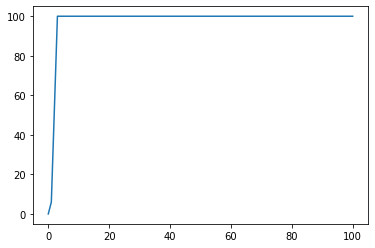

In [549]:
agents = create_agents_jit(100, 25, 10)
pro = simulate_riot_stochastic_jit(agents)
plt.figure()
plt.plot(pro)
#plt.ylim(-5,105)
plt.show()

In [550]:
@numba.njit
def simulate_riot_stochastic_jit2(agents, steps = 100):
    """
    Inputs:
        agents := Agents array
        steps := number of the simulation's time steps
    
    This function calculates the size of an riot according with the stochastic threshold model: The Agent has a higher probability of entering the riot if its threshold value 
    is less or equal to the number (or percentage) of people rioting, and has a low probability of entering the riot if its threshold value is less than the number (or percentage)
    of people rioting.
    
    Outputs:
        A np.array with the sorted thresholds values
    
    """
    
    riot_size = 0
    progression = np.zeros(steps+1)              # array that stores the riot's evolution over time
    aux = 0
    
    for i in range(1,steps+1):
        for agent in agents:
            aux += agent.update_state(riot_size)
        
        
        if aux == 0:
            break
            
        riot_size += aux            
        progression[i] = riot_size
        aux = 0
        
    return progression[:i]

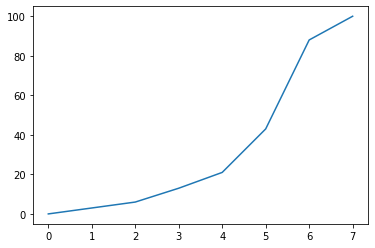

In [551]:
agents = create_agents_jit(100, 25, 10)
pro = simulate_riot_stochastic_jit2(agents)
plt.figure()
plt.plot(pro)
#plt.ylim(-5,105)
plt.show()

In [12]:
@njit
def simulate_riot_stochastic_exit(agents, steps = 100):
    """
    Inputs:
        agents := Agents array
        steps := number of the simulation's time steps
    
    This function calculates the size of an riot according with the stochastic threshold model: The Agent has a higher probability of entering the riot if its threshold value is less or equal to the number
    (or percentage) of people rioting, and has a low probability of entering the riot if its threshold value is less than the number (or percentage) of people rioting. Moreover, there is a chance of an Agent
    to exit the riot according to a logistic function.
    
    Outputs:
        A np.array with the sorted thresholds values
    
    """
    
    riot_size = 0
    progression = np.zeros(steps+1)                                     # array that stores the riot's evolution over time
    
    for i in range(1,steps+1):
        for agent in agents:
            riot_size += agent.update_state_exit(riot_size)

        progression[i] = riot_size
        
    return progression

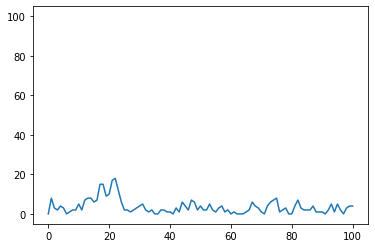

In [30]:
agents = create_agents_jit(100, 30, 10)
pro = simulate_riot_stochastic_exit(agents)
plt.figure()
plt.plot(pro)
plt.ylim(-5,105)
plt.show()

In [141]:
@numba.njit
def simulate_riot_sectors(system, steps = 50):
    """
    Inputs:
        system := System class variable that contains all Agents
        steps := number of the simulation's time steps
    
    This functions simulates a set of 2 simultaneous riots that occur in 2 distinct sectors using the stochastic threshold model. There are a set of Agents in a reservoir that can
    enter sectors 0 or 1 to riot. Each sector has a size, so the thrsehold of each Agent is based on the number of Agents rioting in a sector compared with the number of Agents that
    can be in that sector.
     
    
    Outpurs:
         A np.array "progression" that contains the time evolution of each riots over time.
         
    """

    progression = np.zeros((2,steps+1))              # array that stores the riot's evolution over time
    
    for i in range(1,steps+1):
        system.update_wishes_reservoir()             # check reservoir Agents (enter riot)
        system.update_reservoir()                    # move Agents from reservoir
           
        progression[0][i] = len(system.sector0)
        progression[1][i] = len(system.sector1)
            
    return progression

In [144]:
def zas():
    N = 2000
    average = 30
    deviation = 12

    agents = create_agents_jit(N,average,deviation)

    sector0_size = 1000
    sector1_size = 1000

    system = System(agents, sector0_size, sector1_size)

    steps = 100

    progression = simulate_riot_sectors(system, steps)

    plt.figure()
    plt.plot(progression[0])
    plt.plot(progression[1])
    plt.ylim(-3,N)
    plt.show()

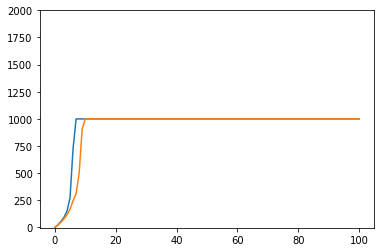

Wall time: 125 ms


In [147]:
%time _ = zas()

100.00%


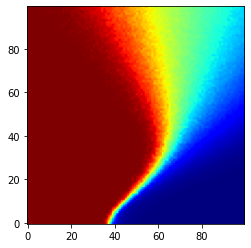

In [416]:
N = 200
averages_sample = np.arange(0,100)  # average value of the normal distribution
deviations = np.arange(0,100)       # standard deviations of the normal distribution

sector0_size = 100
sector1_size = 100

steps = 100
simulations = 100

heat_map = np.zeros((100,100))

for k in averages_sample:
    clear_output(wait=True)
    print(str("%.2f" % (100*k/99)+"%"), end="\n")

    for i in deviations:         # a set of simulations per standard deviation value
        average_size = 0

        for j in range(simulations):   # riot simulation
            agents = create_agents_jit(N,k,i)
            system = System(agents, sector0_size, sector1_size)
            final = simulate_riot_sectors(system, steps)[0][-1]
            average_size += final

        average_size = average_size/simulations
        heat_map[i][k] = average_size

plt.figure()
plt.imshow(heat_map, origin="lower",cmap="jet")
#plt.savefig("Média e Desvio Padrão - Determinístico")
plt.show()

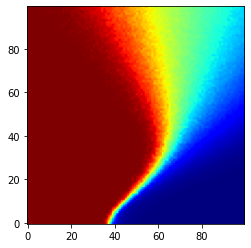

In [417]:
plt.figure()
plt.imshow(heat_map, origin="lower",cmap="jet")
#plt.savefig("Média e Desvio Padrão - Determinístico")
plt.show()

In [26]:
@numba.njit
def simulate_riot_sectors_exit(system, steps = 50):
    """
    Inputs:
        system := System class variable that contains all Agents
        steps := number of the simulation's time steps
    
    This functions simulates a set of 2 simultaneous riots that occur in 2 distinct sectors using the stochastic threshold model. There are a set of Agents in a reservoir that can
    enter sectors 0 or 1 to riot. Each sector has a size, so the thrsehold of each Agent is based on the number of Agents rioting in a sector compared with the number of Agents that
    can be in that sector. In this function, the Agents can exit the riot and return to the reservoir according to a logistic function.
     
    
    Outpurs:
         A np.array "progression" that contains the time evolution of each riots over time.
         
    """
    
    progression = np.zeros((2,steps+1))              # array that stores the riot's evolution over time
    
    for i in range(1,steps+1):
        system.update_wishes_reservoir()             # check reservoir Agents (enter riot)
        system.update_wishes_sectors_exit()          # check sectors Agents (leave riot)
        system.update_reservoir()                    # move Agents from reservoir
        system.update_sectors()                      # move Agents from sectors
           
        progression[0][i] = len(system.sector0)
        progression[1][i] = len(system.sector1)
            
    return progression

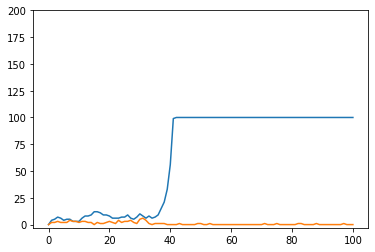

In [41]:
N = 200
average = 45
deviaition = 20

sector0_size = 100
sector1_size = 100
agents0 = create_agents_jit(N,average,deviaition)

system = System(agents0, sector0_size, sector1_size)

steps = 100

progression = simulate_riot_sectors_exit(system, steps)


plt.figure()
plt.plot(progression[0])
plt.plot(progression[1])
plt.ylim(-3,N)
plt.show()

In [42]:
@numba.njit
def simulate_riot_sectors_migration(system, steps = 50, migration_probability = 0.01):
    """
    Inputs:
        system := System class variable that contains all Agents
        steps := number of the simulation's time steps
    
    This functions simulates a set of 2 simultaneous riots that occur in 2 distinct sectors using the stochastic threshold model. There are a set of Agents in a reservoir that can
    enter sectors 0 or 1 to riot. Each sector has a size, so the thrsehold of each Agent is based on the number of Agents rioting in a sector compared with the number of Agents that
    can be in that sector. In this function, the Agents in a section can migrate to the other sector with probability equals to "migration_probability".
     
    
    Outpurs:
         A np.array "progression" that contains the time evolution of each riots over time.
         
    """
    
    progression = np.zeros((2,steps+1))              # array that stores the riot's evolution over time
    
    for i in range(1,steps+1):
        system.update_wishes_reservoir()                                     # check reservoir Agents (enter riot)
        system.update_wishes_sectors_migration_random(migration_probability) # check sectors Agents (migrate to other sector)
        system.update_reservoir()                                            # move Agents from reservoir
        system.update_sectors()                                              # move Agents from sectors
           
        progression[0][i] = len(system.sector0)
        progression[1][i] = len(system.sector1)
            
    return progression

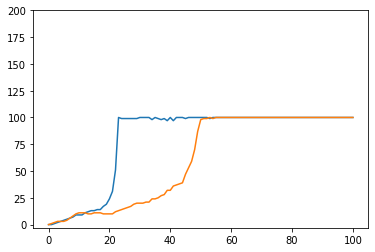

In [52]:
importlib.reload(func)
N = 200
average = 45
deviaition = 20

sector0_size = 100
sector1_size = 100
agents0 = create_agents_jit(N,average,deviaition)

system = System(agents0, sector0_size, sector1_size)

steps = 100

progression = simulate_riot_sectors_migration(system, steps)


plt.figure()
plt.plot(progression[0])
plt.plot(progression[1])
plt.ylim(-3,N)
plt.show()

In [101]:
@numba.njit
def simulate_riot_sectors_migration_exit(system, steps = 50, migration_probability = 0.01, start = 0):
    """
    Inputs:
        system := System class variable that contains all Agents
        steps := number of the simulation's time steps
        start := the time step value when the Agents can migrate between sectors
    
    This functions simulates a set of 2 simultaneous riots that occur in 2 distinct sectors using the stochastic threshold model. There are a set of Agents in a reservoir that can
    enter sectors 0 or 1 to riot. Each sector has a size, so the thrsehold of each Agent is based on the number of Agents rioting in a sector compared with the number of Agents that
    can be in that sector. In this function, the Agents in a section can migrate to the other sector with probability equals to "migration_probability" if "i", the current time step is
    greater or equal to "start". Moreover, the Agents can exit the riot and return to the reservoir according to a logistic function.
     
    
    Outpurs:
         A np.array "progression" that contains the time evolution of each riots over time.
        
    """
    
    progression = np.zeros((2,steps+1))              # array that stores the riot's evolution over time
    
    for i in range(1,steps+1):
        system.update_wishes_reservoir()                                         # check reservoir Agents (enter riot)
        system.update_wishes_sectors_exit()                                      # check sectors Agents (leave riot)
        if i >= start:
            system.update_wishes_sectors_migration_random(migration_probability) # check sectors Agents (migrate to other sector)
        system.update_reservoir()                                                # move Agents from reservoir
        system.update_sectors()                                                  # move Agents from sectors
           
        progression[0][i] = len(system.sector0)
        progression[1][i] = len(system.sector1)
            
    return progression

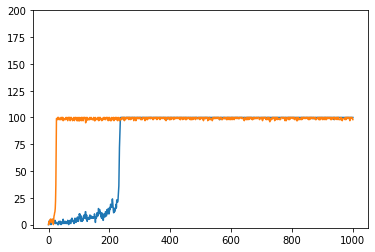

In [102]:
N = 200
average = 45
deviaition = 20

sector0_size = 100
sector1_size = 100
agents0 = create_agents_jit(N,average,deviaition)

system = System(agents0, sector0_size, sector1_size)

steps = 1000

migration_probability = 0.01

progression = simulate_riot_sectors_migration_exit(system, steps, migration_probability)


plt.figure()
plt.plot(progression[0])
plt.plot(progression[1])
plt.ylim(-3,N)
plt.show()

In [106]:
@numba.njit
def simulate_riot_sectors_migration_gregarious(system, steps = 50, start = 0):
    """
    Inputs:
        system := System class variable that contains all Agents
        steps := number of the simulation's time steps
        start := the time step value when the Agents can migrate between sectors
    
    This functions simulates a set of 2 simultaneous riots that occur in 2 distinct sectors using the stochastic threshold model. There are a set of Agents in a reservoir that can
    enter sectors 0 or 1 to riot. Each sector has a size, so the thrsehold of each Agent is based on the number of Agents rioting in a sector compared with the number of Agents that
    can be in that sector. In this function, the Agents in a section can migrate to the other sector according to the difference between the number of Agents in each sector if "i",
    the current time step is greater or equal to "start".
     
    
    Outpurs:
         A np.array "progression" that contains the time evolution of each riots over time.
        
    """
    
    progression = np.zeros((2,steps+1))              # array that stores the riot's evolution over time
    
    for i in range(1,steps+1):
        system.update_wishes_reservoir()                                             # check reservoir Agents (enter riot)
        if i >= start:
            system.update_wishes_sectors_migration_gregarious() # check sectors Agents (migrate to other sector)
        system.update_reservoir()                                                    # move Agents from reservoir
        system.update_sectors()                                                      # move Agents from sectors
           
        progression[0][i] = len(system.sector0)
        progression[1][i] = len(system.sector1)
            
    return progression

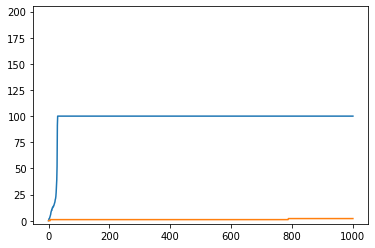

In [129]:
N = 200
average = 55
deviaition = 20

sector0_size = 100
sector1_size = 100
agents0 = create_agents_jit(N,average,deviaition)

system = System(agents0, sector0_size, sector1_size)

steps = 1000
start = 0

progression = simulate_riot_sectors_migration_gregarious(system, steps, start)


plt.figure()
plt.plot(progression[0])
plt.plot(progression[1])
plt.ylim(-3,N+5)
plt.show()

In [136]:
@numba.njit
def simulate_riot_sectors_migration_gregarious_exit(system, steps = 50, start = 0):
    """
    Inputs:
        system := System class variable that contains all Agents
        steps := number of the simulation's time steps
        start := the time step value when the Agents can migrate between sectors
    
    This functions simulates a set of 2 simultaneous riots that occur in 2 distinct sectors using the stochastic threshold model. There are a set of Agents in a reservoir that can
    enter sectors 0 or 1 to riot. Each sector has a size, so the thrsehold of each Agent is based on the number of Agents rioting in a sector compared with the number of Agents that
    can be in that sector. In this function, the Agents in a section can migrate to the other sector according to the difference between the number of Agents in each sector if "i",
    the current time step is greater or equal to "start". Moreover, the Agents can exit the riot and return to the reservoir according to a logistic function.
     
    
    Outpurs:
         A np.array "progression" that contains the time evolution of each riots over time.
        
    """
    
    progression = np.zeros((2,steps+1))              # array that stores the riot's evolution over time
    
    for i in range(1,steps+1):
        system.update_wishes_reservoir()                                             # check reservoir Agents (enter riot)
        system.update_wishes_sectors_exit()                                          # check sectors Agents (leave riot)
        if i >= start:
            system.update_wishes_sectors_migration_gregarious() # check sectors Agents (migrate to other sector)
        system.update_reservoir()                                                    # move Agents from reservoir
        system.update_sectors()                                                      # move Agents from sectors
           
        progression[0][i] = len(system.sector0)
        progression[1][i] = len(system.sector1)
            
    return progression

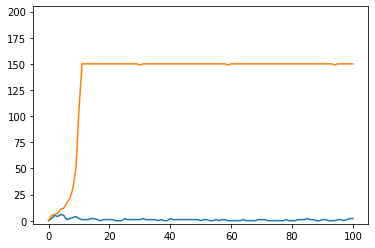

In [137]:
N = 200
average = 35
deviaition = 20

sector0_size = 150
sector1_size = 150
agents0 = create_agents_jit(N,average,deviaition)

system = System(agents0, sector0_size, sector1_size)

steps = 100

progression = simulate_riot_sectors_migration_gregarious_exit(system, steps)


plt.figure()
plt.plot(progression[0])
plt.plot(progression[1])
plt.ylim(-3,N+5)
plt.show()